# Kendrick Mass Filter 
 __Authors:__ Ricardo R. da Silva (ridasilva@ucsd.edu), Madeleine Ernst (mernst@ucsd.edu), Alan K. Jarmusch (ajarmusch@ucsd.edu) <br>
 __Verion:__ 1.0 (Prior to Submission of Manuscript) <br>
 __Date of Last Revision:__ 06-21-2018 <br>
 
**Description**: Kendrick mass is the mass-to-charge (*m/z*) of each ion rescaled to an integer value of a given unit repeat. The defect between the Kendrick scaled *m/z* and the integer Kendrick mass value, i.e. Kendrick mass defect (KMD), is similar between homologous compounds. The Kendrick Mass Filter (MDF) is used to perform selection and removal of data centered around a user-defined KMD, with addtional restrictions on the elution time and presence of possibly multiple homologous compounds eluting together. This notebook calculates and visualizes data output obtained through the Kendrick Mass Filter for a selected dataset using user-defined parameters.

**Input**: <br>
<ul>
<li>**Feature table**: (.csv) file with MS features in columns and samples in rows. Feature IDs are provided in the column names in the following format: "mz;RT". The first column must contain sample names. </li>
</ul> <br>
**Output**: <br>
<ul>
<li>**Summary tables**: (.csv) files containing Kendrick mass filtered output data. </li>
<li>**Plots** (.pdf): Kendrick mass plot, MS1 features plot and spectra before and after applying KMF.</li>
</ul> <br> 
**Dependencies**: R version 3.4.2 (2017-09-28) and packages: tidyr_0.8.0, dplyr_0.7.4, gridExtra_2.3, gtable_0.2.0, Rgraphviz_2.22.0, graph_1.56.0, BiocGenerics_0.24.0, Hmisc_4.0-3, ggplot2_2.2.1, Formula_1.2-2, survival_2.41-3, lattice_0.20-35 

load libraries

In [1]:
library(Hmisc)
library(Rgraphviz)
library(graph)
library(ggplot2)
library(gtable)
library(grid)
library(gridExtra)
library(dplyr)
library(tidyr)

Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: 'Hmisc'

The following objects are masked from 'package:base':

    format.pval, units

Loading required package: graph
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pma

load Kendrick Mass Filter source function

In [2]:
source("kendrick.mass.filter_new_all_datamatrix_terminologyupdate.R")

# Data Input and Preparation for Kendrick Mass Filter

load data matrix (samples in rows and variables in columns)

In [1]:
data_matrix <- read.csv("PEG_KMF_resultingdatamatrix.csv", header=T, check.names=F)

Prepare data for Kendrick Mass Filter: create a matrix containing one column with *m/z* values and another column with RT values

In [4]:
vec <- do.call(rbind,lapply(strsplit(colnames(data_matrix)[2:ncol(data_matrix)],";"),matrix,ncol=2,byrow=TRUE))
class(vec) <- "numeric"
colnames(vec)<- c("mz","rt")
head(vec)

mz,rt
356.3886,7.804624
367.3320,6.990095
482.5283,8.711017
282.2789,9.140700
172.1329,8.829460
370.3669,8.671656


In [5]:
dim(data_matrix)

[1]   83 3406

# Apply Kendrick Mass Filter to data
Parameters, which can be specified when running the mass filter: <br>
1. __Kendrick mass defect (KMD) [Da]__ - tolerance of mass defect. Smaller values result in a more stingent homology parameter. <br>
2. __Retention time (RT) [min]__ - tolerance for chromatographic elution. <br>
3. __Number of Observations (NOS)__ - how many oligomer peaks must be observed. Larger values result in more specificity. 
4. __connection_filter__ must be set to "TRUE" for NOS parameter to function correctly. <br>
5. __polymer__ - selection of polymers or signals to filter, options are:<br>
alkane_other_CH2, oxidation, water_cluster, alkane_C2H4, methanol_cluster, acetonitrile_cluster, propylation_other_C3H6, polyethylene_glycol_other_C2H4O1, perfluoro_CF2, ammoniumchloride_cluster, butylation_other_C4H8, sodiumchloride_cluster, polypropylene_glycol_other_C3H6O1, ammoniumformate_cluster, sodiumformate_cluster, potassiumchloride_cluster, polysiloxane, <br> sodiumacetate_cluster

run the Kendrick Mass Filter with user-specified parameters

In [6]:
output <- Kendrick.mass.filter(
    data_matrix, 
    vec,
    polymer = "polypropylene_glycol_other_C3H6O1", 
    KMD = 0.01, 
    RT = 0.8, 
    NOS = 5, 
    connection_filter = TRUE)

show output table

# Kendrick Mass Plot

create Kendrick mass plot

In [8]:
kendrickmassfilterinfo <- as.data.frame(output$kendrickmassfilterinfo_original)
kendrickmassfilterinfo_filtered_wgraph <- as.data.frame(output$kendrickmassfilterinfo_filtered_wgraph)
kendrickmassfilterinfo_diff <- kendrickmassfilterinfo[((kendrickmassfilterinfo[,1] %in% 
                                                        kendrickmassfilterinfo_filtered_wgraph[,1]) & 
                                                       (kendrickmassfilterinfo[,2] %in% 
                                                        kendrickmassfilterinfo_filtered_wgraph[,2])) != TRUE,]

Original MS1 features are displayed in black, and filtered MS1 features in red. Homologous compounds (polymers) can be readily identified by plotting the integer Kendrick values versus the Kendrick mass defect, resulting in a horizontal alignment in the Kendrick mass plot. 

Saving 6.67 x 6.67 in image


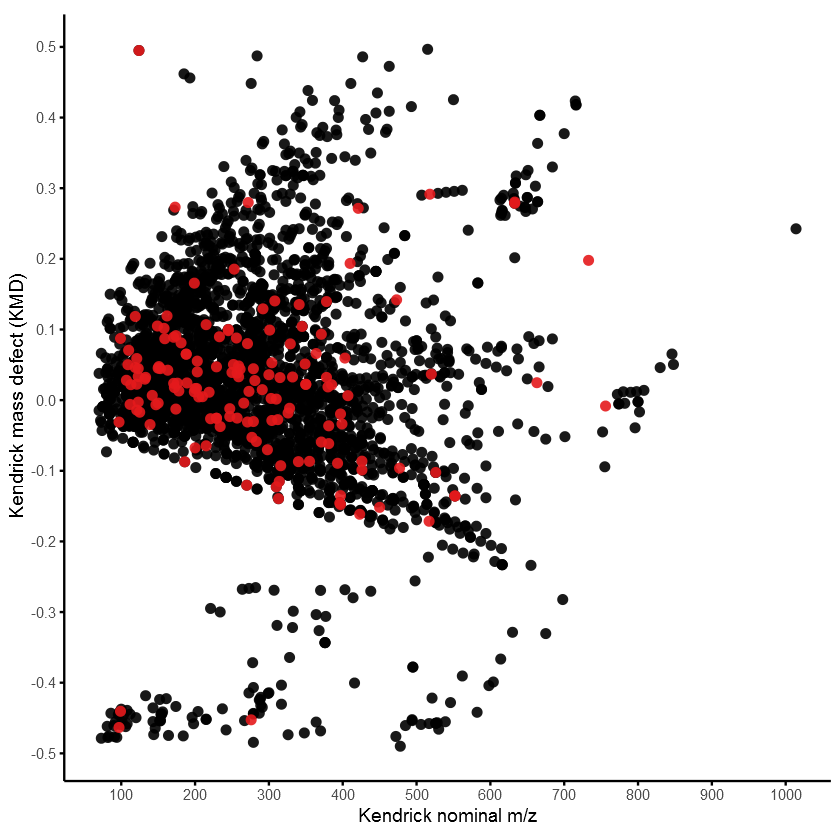

In [9]:
Kendrickplot <- 
    ggplot()+
    geom_point(data=as.data.frame(output$kendrickmassfilterinfo_filtered_wgraph), aes(x=nom_kend, y=msdefect), pch=16, 
               size=2.5, alpha=0.9, col="black")+
    geom_point(data=kendrickmassfilterinfo_diff,aes(x=nom_kend,y=msdefect), pch=16, 
               size=2.5, alpha=0.9,  col="#e41a1c")+
    scale_y_continuous(breaks = seq(-0.5,0.5,0.1))+
    scale_x_continuous(breaks = seq(0,1000,100))+
    xlab("Kendrick nominal m/z") +
    ylab("Kendrick mass defect (KMD)") +
    theme_minimal() +
    theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="bottom",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_text("DBS Features Filtered"),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
print(Kendrickplot)
ggsave("Kendrickmassplot_Autism_0.01_0.8_5_V2.2_PPG.pdf")

Following Fouquet and Sato (Anal. Chem. 2017, 89, 2682−2686) definitions of KM as


\begin{equation}
KM(ion) = m/z(ion) * \frac{round(m(base\ unit))}{m(base\ unit)}
\end{equation}

NKM as

\begin{equation}
NKM(ion) = round(KM(ion)) 
\end{equation}

and KMD as

\begin{equation}
KMD(ion) = NKM(ion) - KM(ion)
\end{equation}

and CNKM as

\begin{equation}
CNKM(ion) = NKM(ion) - celling(NKM(ion)-m/z(ion))
\end{equation}

The expansion of the KMD dimension is accomplished using a fractional base unit 

\begin{equation}
base\ unit = \frac{(base\ unit)}{X}
\end{equation}

# MS1 Feature Plot

create MS1 feature plot

In [10]:
#colnames(output$Kendrickfiltered_MS1features_wgraph)
KMF_vec <- do.call(rbind,lapply(strsplit(colnames(output$Kendrickfiltered_MS1features_wgraph)[2:ncol(output$Kendrickfiltered_MS1features_wgraph)],";"),matrix,ncol=2,byrow=TRUE))
class(KMF_vec) <- "numeric"
colnames(KMF_vec)<- c("mz","rt")
head(KMF_vec)

mz,rt
356.3886,7.804624
367.3320,6.990095
482.5283,8.711017
282.2789,9.140700
172.1329,8.829460
370.3669,8.671656


In [11]:
Filtered_matrix_KMF_wgraph_MS1_plot_vec <- as.data.frame(vec[((vec[,1] %in% KMF_vec[,1]) & (vec[,2] %in% KMF_vec[,2])) != TRUE,])

Original MS1 features are displayed in black, and filtered MS1 features in red.

Saving 6.67 x 6.67 in image


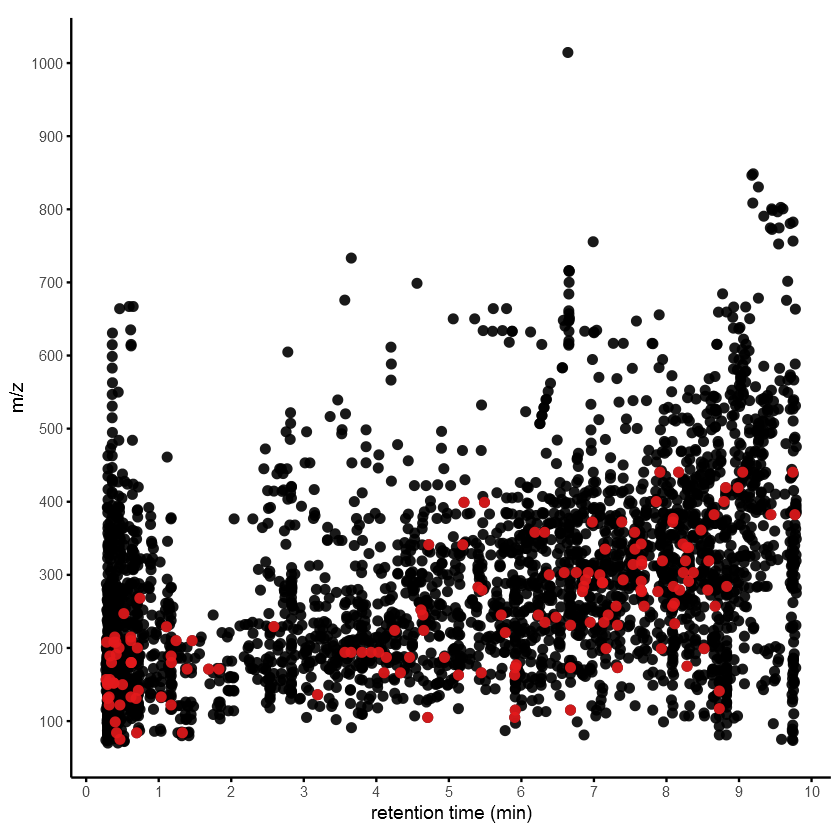

In [12]:
MS1featureplot <- 
    ggplot()+
    geom_point(data=as.data.frame(vec),aes(x=rt, y=mz), pch=16, 
              size=2.5, alpha=0.9, color="black")+
    geom_point(data=Filtered_matrix_KMF_wgraph_MS1_plot_vec, aes(x=rt, y=mz), pch=16, 
               size=2.5, alpha=0.9, col="#e41a1c")+
    scale_y_continuous(breaks = seq(0,1000,100))+
    scale_x_continuous(breaks = seq(0,10,1))+
        xlab("retention time (min)") +
        ylab("m/z") +
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="bottom",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_text("DBS Features Filtered"),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
print(MS1featureplot)
ggsave("MS1featureplot_Autism_V2.2_PPG.pdf")

# Plot Spectra

create MS1 feature spectrum prior to KMF

In [13]:
original_spectrum <- as.data.frame(cbind(vec,as.numeric(t(data_matrix)[2:nrow(t(data_matrix)),2])))
label <- format(round(vec[,1], 2), nsmall = 4)
original_spectrum <- cbind(original_spectrum, label)
colnames(original_spectrum) <- c("mz","rt","abundance","mz_label")
head(original_spectrum)

mz,rt,abundance,mz_label
<dbl>,<dbl>,<dbl>,<fct>
356.3886,7.804624,3.61e+09,356.3900
367.3320,6.990095,4.76e+08,367.3300
482.5283,8.711017,3.61e+08,482.5300
282.2789,9.140700,1.38e+08,282.2800
172.1329,8.829460,3.55e+08,172.1300
370.3669,8.671656,1.66e+08,370.3700


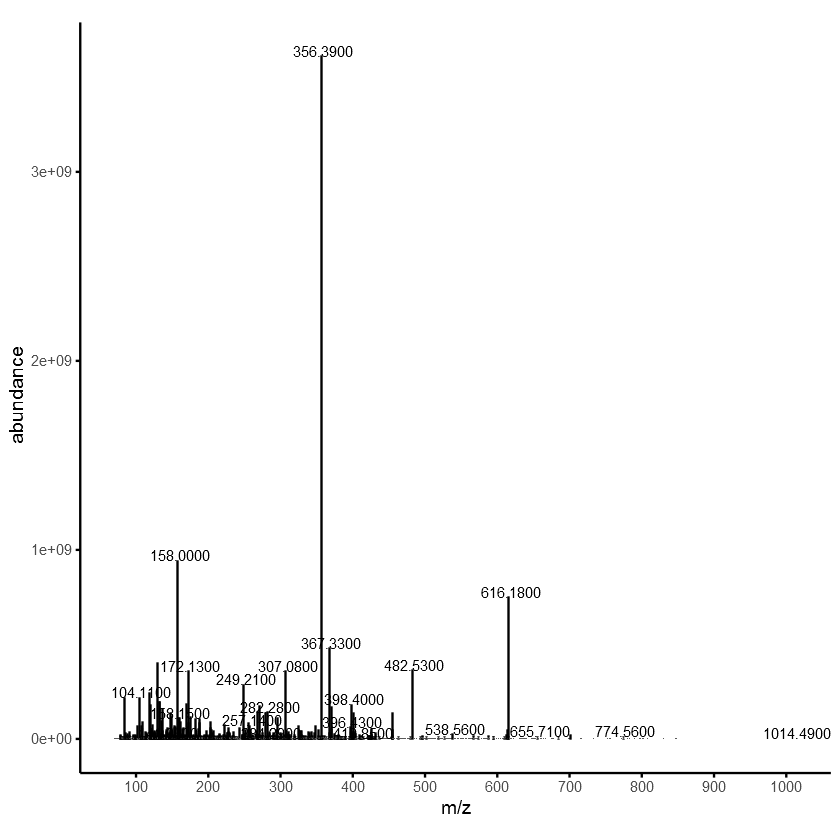

In [14]:
# Original spectrum
Original_Spectrum_plot <- 
    ggplot()+
    geom_bar(data=original_spectrum,aes(x=mz, y=abundance), stat="identity",  
              size=0.5, alpha=1, color="black")+
    geom_text(data=original_spectrum,aes(x=mz, y=abundance,label=mz_label), cex=3, check_overlap = TRUE, vjust=0) +
   scale_x_continuous(breaks = seq(0,1000,100))+
        xlab("m/z") +
        ylab("abundance") +
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="bottom",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_text("DBS Features Filtered"),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
print(Original_Spectrum_plot)

create MS1 feature spectrum after KMF

In [15]:
KMF_spectrum <- as.data.frame(cbind(KMF_vec,as.numeric(t(output$Kendrickfiltered_MS1features_wgraph)[2:nrow(t(output$Kendrickfiltered_MS1features_wgraph)),2])))
label <- format(round(KMF_vec[,1], 2), nsmall = 4)
KMF_spectrum <- cbind(KMF_spectrum, label)
colnames(KMF_spectrum) <- c("mz","rt","abundance","mz_label")
head(KMF_spectrum)

mz,rt,abundance,mz_label
<dbl>,<dbl>,<dbl>,<fct>
356.3886,7.804624,3.61e+09,356.3900
367.3320,6.990095,4.76e+08,367.3300
482.5283,8.711017,3.61e+08,482.5300
282.2789,9.140700,1.38e+08,282.2800
172.1329,8.829460,3.55e+08,172.1300
370.3669,8.671656,1.66e+08,370.3700


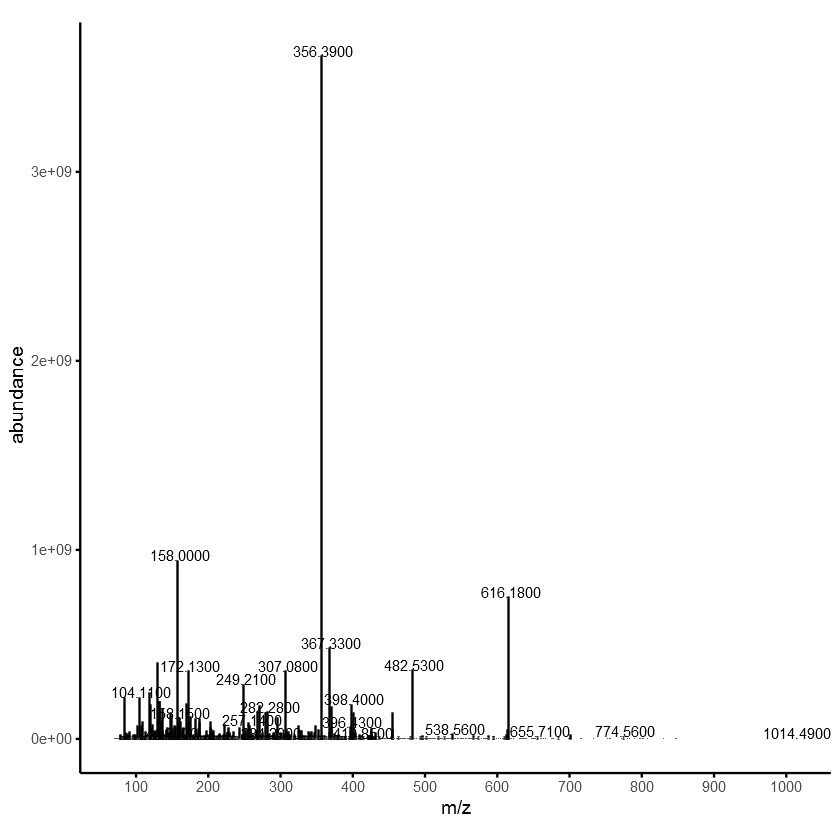

In [16]:
KMF_spectrum_plot <- 
    ggplot()+
    geom_bar(data=KMF_spectrum,aes(x=mz, y=abundance), stat="identity",  
              size=0.5, alpha=1, color="black")+
    geom_text(data=KMF_spectrum,aes(x=mz, y=abundance,label=mz_label), cex=3, check_overlap = TRUE, vjust=0) +
   scale_x_continuous(breaks = seq(0,1000,100))+
        xlab("m/z") +
        ylab("abundance") +
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="bottom",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_text("DBS Extract Features Filtered"),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
print(KMF_spectrum_plot)

create spectrum of MS1 features removed via KMF

In [17]:
# MS1 Features (calculate MS1 Features that were removed rather than retained)
Filtered_matrix_KMF_wgraph_MS1_plot <- 
   t(data_matrix)[which(((vec[,1] %in% KMF_vec[,1]) & 
                  (vec[,2] %in% KMF_vec[,2])) != TRUE)+1,]

In [19]:
which(((vec[,1] %in% KMF_vec[,1]) & 
                  (vec[,2] %in% KMF_vec[,2])) != TRUE)

[1]  106  111  118  165  199  226  231  259  269  303  315  330  333  348  365
 [16]  366  394  448  451  465  478  493  512  526  533  545  558  579  621  720
 [31]  727  738  743  747  770  804  876  935  956  974  996 1040 1057 1075 1098
 [46] 1111 1134 1236 1261 1285 1286 1304 1322 1328 1349 1365 1369 1408 1418 1459
 [61] 1470 1491 1507 1516 1534 1579 1608 1622 1643 1684 1686 1701 1724 1729 1730
 [76] 1745 1783 1790 1796 1805 1814 1853 1874 1891 1906 1982 1984 2002 2014 2044
 [91] 2063 2078 2079 2091 2114 2139 2237 2250 2268 2282 2316 2365 2374 2380 2391
[106] 2407 2424 2431 2447 2474 2485 2526 2534 2555 2559 2564 2589 2675 2692 2695
[121] 2716 2734 2746 2773 2790 2800 2836 2856 2928 2940 2941 2989 3023 3027 3031
[136] 3044 3045 3046 3051 3061 3076 3102 3125 3162 3165 3180 3224 3268 3292 3320
[151] 3342 3350

In [20]:
vec[1:15,]

mz,rt
356.3886,7.8046236
367.3320,6.9900947
482.5283,8.7110173
282.2789,9.1407005
172.1329,8.8294598
370.3669,8.6716557
249.2060,6.6776203
158.0028,0.2964949
104.1069,0.3900365
256.2632,9.1025802


In [21]:
KMF_vec[1:15,]

mz,rt
356.3886,7.8046236
367.3320,6.9900947
482.5283,8.7110173
282.2789,9.1407005
172.1329,8.8294598
370.3669,8.6716557
249.2060,6.6776203
158.0028,0.2964949
104.1069,0.3900365
256.2632,9.1025802


In [22]:
KMF_filtered_features_spectrum <- as.data.frame(cbind(Filtered_matrix_KMF_wgraph_MS1_plot_vec, 
                                                      as.numeric(Filtered_matrix_KMF_wgraph_MS1_plot[,2])))
label <- format(round(Filtered_matrix_KMF_wgraph_MS1_plot_vec[,1], 2), nsmall = 4)
KMF_filtered_features_spectrum <- cbind(KMF_filtered_features_spectrum, label)
colnames(KMF_filtered_features_spectrum) <- c("mz","rt","abundance","mz_label")
head(KMF_filtered_features_spectrum)

mz,rt,abundance,mz_label
<dbl>,<dbl>,<dbl>,<fct>
115.1117,5.915859,28800000,115.1100
173.1536,6.677084,29400000,173.1500
284.2696,6.859470,32200000,284.2700
400.3422,7.859196,33300000,400.3400
115.1117,6.677049,12000000,115.1100
199.1691,8.519285,8782142,199.1700


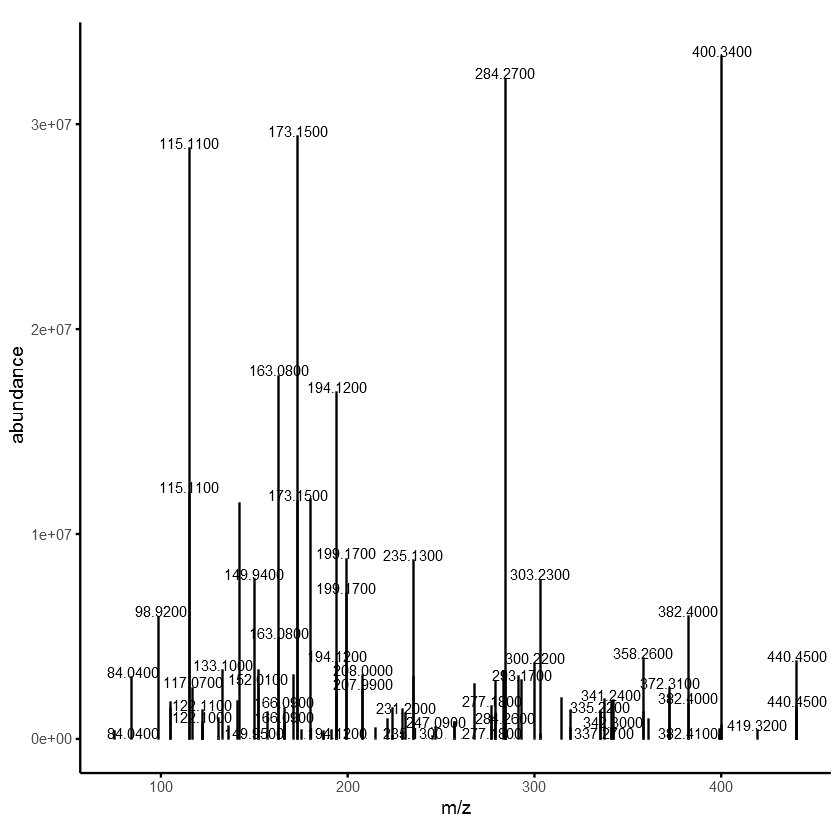

In [23]:
KMF_filtered_features_spectrum_plot <- ggplot()+
    geom_bar(data=KMF_filtered_features_spectrum,aes(x=mz, y=abundance), stat="identity",size=0.5, alpha=1, color="black")+
    geom_text(data=KMF_filtered_features_spectrum,aes(x=mz, y=abundance,label=mz_label), cex=3, check_overlap = TRUE, vjust=0) +
    scale_x_continuous(breaks = seq(0,1000,100))+
    xlab("m/z") +
    ylab("abundance") +
    theme_minimal() +
    theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="bottom",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_text("DBS Features Filtered"),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
print(KMF_filtered_features_spectrum_plot)

create a) Kendrick mass plot, b) MS1 feature plot, c) MS1 feature spectrum prior and d) after KMF as well as e) MS1 features removed via KMF:

Saving 7.1 x 6.67 in image


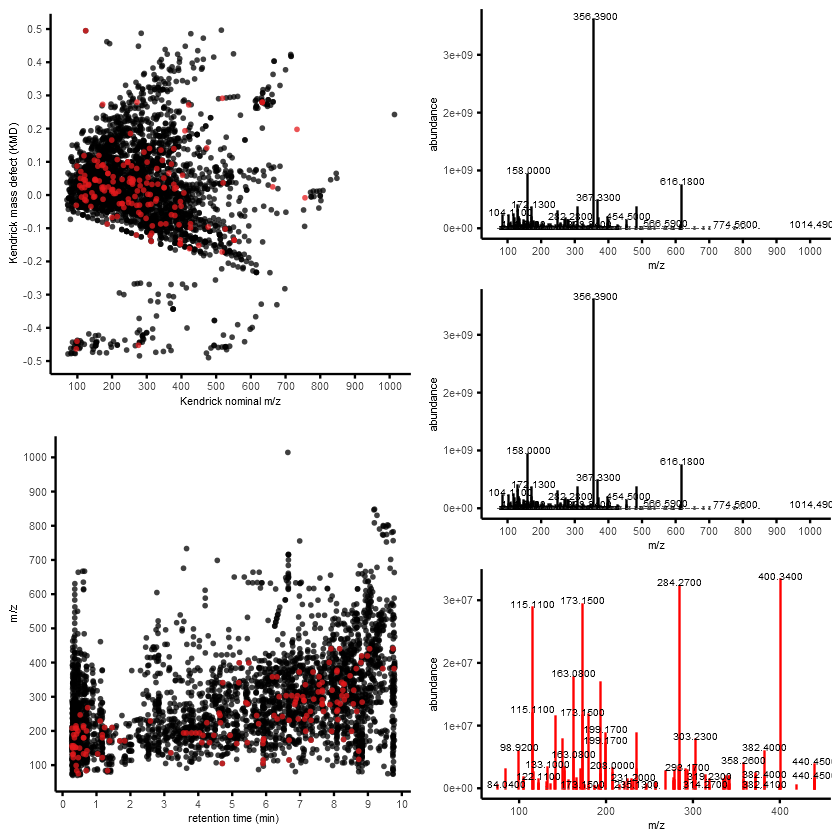

In [24]:
Kendrickplot <- 
    ggplot()+
    geom_point(data=as.data.frame(output$kendrickmassfilterinfo_filtered_wgraph), aes(x=nom_kend, y=msdefect), pch=16, 
               size=1, alpha=0.75, col="black")+
    geom_point(data=kendrickmassfilterinfo_diff,aes(x=nom_kend,y=msdefect), pch=16, 
               size=1, alpha=0.75,  col="#e41a1c")+
    scale_y_continuous(breaks = seq(-0.5,0.5,0.1))+
    scale_x_continuous(breaks = seq(0,1000,100))+
    xlab("Kendrick nominal m/z") +
    ylab("Kendrick mass defect (KMD)") +
    theme_minimal() +
    theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.title.x=element_text(size=6),
               axis.title.y=element_text(size=6),
               axis.text=element_text(size=6),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
    
MS1featureplot <- 
    ggplot()+
    geom_point(data=as.data.frame(vec),aes(x=rt, y=mz), pch=16, 
              size=1, alpha=0.75, color="black")+
    geom_point(data=Filtered_matrix_KMF_wgraph_MS1_plot_vec, aes(x=rt, y=mz), pch=16, 
               size=1, alpha=0.75, col="#e41a1c")+
    scale_y_continuous(breaks = seq(0,1000,100))+
    scale_x_continuous(breaks = seq(0,10,1))+
        xlab("retention time (min)") +
        ylab("m/z") +
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.title.x=element_text(size=6),
               axis.title.y=element_text(size=6),
               axis.text=element_text(size=6),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)

Original_Spectrum_plot <- 
    ggplot()+
    geom_bar(data=original_spectrum,aes(x=mz, y=abundance), stat="identity",  
              size=0.5, alpha=1, color="black")+
    geom_text(data=original_spectrum,aes(x=mz, y=abundance,label=mz_label), size=2, check_overlap = TRUE, vjust=0) +
   scale_x_continuous(breaks = seq(0,1000,100))+
        xlab("m/z") +
        ylab("abundance") +
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.title.x=element_text(size=6),
               axis.title.y=element_text(size=6),
               axis.text=element_text(size=6),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=6)) 

KMF_spectrum_plot <- 
    ggplot()+
    geom_bar(data=KMF_spectrum,aes(x=mz, y=abundance), stat="identity",  
              size=0.5, alpha=1, color="black")+
    geom_text(data=KMF_spectrum,aes(x=mz, y=abundance,label=mz_label), size=2, check_overlap = TRUE, vjust=0) +
   scale_x_continuous(breaks = seq(0,1000,100))+
        xlab("m/z") +
        ylab("abundance") +
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.title.x=element_text(size=6),
               axis.title.y=element_text(size=6),
               axis.text=element_text(size=6),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=6)) 

KMF_filtered_features_spectrum_plot <- ggplot()+
    geom_bar(data=KMF_filtered_features_spectrum,aes(x=mz, y=abundance), stat="identity",size=0.5, alpha=1, color="red")+
    geom_text(data=KMF_filtered_features_spectrum,aes(x=mz, y=abundance,label=mz_label), size=2, check_overlap = TRUE, vjust=0) +
    scale_x_continuous(breaks = seq(0,1000,100))+
    xlab("m/z") +
    ylab("abundance") +
    theme_minimal() +
    theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.title.x=element_text(size=6),
               axis.title.y=element_text(size=6),
               axis.text=element_text(size=6),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=6))  

lay <- rbind(c(1,3),
             c(1,3),
             c(1,4),
             c(2,4),
             c(2,5),
             c(2,5))
plot <- grid.arrange(Kendrickplot,MS1featureplot,Original_Spectrum_plot,KMF_spectrum_plot,KMF_filtered_features_spectrum_plot, layout_matrix = lay)

ggsave("KMF_Figure_PPG_Autism_V2.2.pdf", plot, scale=1, width=7.1, units="in")

save output tables to files

In [25]:
# write .csv table containing the KMF info matrix
write.csv(kendrickmassfilterinfo_diff, "PPG_KMF_infomatrix.csv", row.names=FALSE)

# write .csv table containing MS1 features remaining after Kendrick mass filtering
write.csv(output$Kendrickfiltered_MS1features_wgraph, "PPG_KMF_resultingdatamatrix.csv",row.names=FALSE)

# write .csv table of MS1 features removed from the data via the Kendrick mass filter
write.csv(Filtered_matrix_KMF_wgraph_MS1_plot_vec, "PPG_KMF_featuresfiltered.csv", row.names=FALSE)